In [124]:
#Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

In [125]:
df=pd.read_csv("ratings_Electronics.csv")
df.columns=['userID','productID','Rating','timestamp']
df.shape

(1048575, 4)

In [126]:
df.head()

,userID,productID,Rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [127]:
df.isnull().sum()

userID       0
productID    0
Rating       0
timestamp    0
dtype: int64

In [128]:
df.dtypes

userID       object
productID    object
Rating        int64
timestamp     int64
dtype: object

In [129]:
df.userID = df.userID.astype('str')
df.productId = df.productID.astype('str')

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
userID       1048575 non-null object
productID    1048575 non-null object
Rating       1048575 non-null int64
timestamp    1048575 non-null int64
dtypes: int64(2), object(2)
memory usage: 32.0+ MB


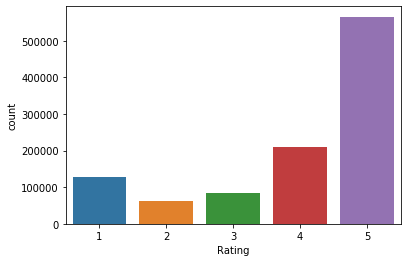

In [131]:
sns.countplot(df.Rating)

Looks like a very high proportion of ratings received is either 5 or 4. Next highest count of ratings received is for 1 which is still a very high number (=100000).

Lets compare the average rating for each product vs the number of people who rated for the product. This will help identify products which have a very high or low rating because of very few ratings received. Those are like outliers.

In [132]:
ratings=pd.DataFrame(df.groupby('productID')['Rating'].mean())
ratings['Number_Of_Ratings']=pd.DataFrame(df.groupby('productID')['Rating'].count())
ratings.head()

,Rating,Number_Of_Ratings
productID,,
059400232X,5.0,3
089933623X,2.5,2
094339676X,5.0,1
1034385789,4.4,5
1039869017,5.0,2


Looks like there are a few products with very few ratings received.

Let's now check the distribution of count of ratings and the mean ratings

Text(0.5, 1.0, 'Distribution of Ratings')

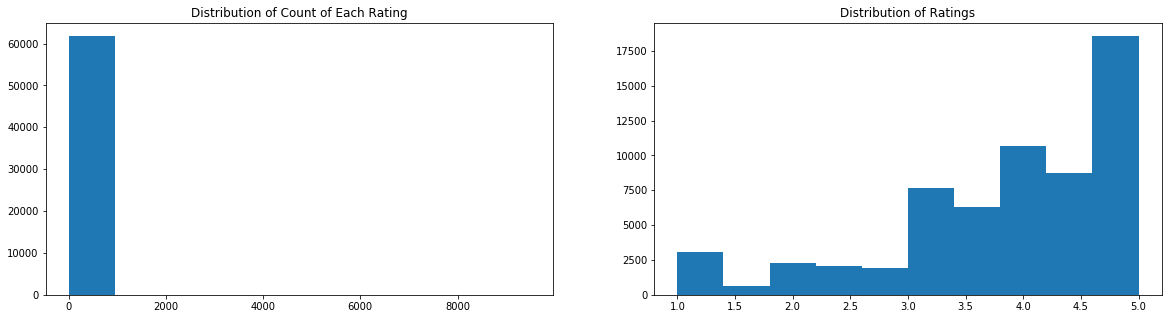

In [133]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings.Number_Of_Ratings)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings.Rating)
plt.title('Distribution of Ratings')

In [134]:
ratings.describe()

,Rating,Number_Of_Ratings
count,61893.000000,61893.000000
mean,3.853758,16.941738
std,1.076955,89.707538
min,1.000000,1.000000
25%,3.250000,1.000000
50%,4.000000,3.000000
75%,4.750000,9.000000
max,5.000000,9487.000000


In [135]:
#There seems to be a few outliers for Number of Ratings. The highest value is insanely high.

Q1=np.percentile(ratings['Number_Of_Ratings'],25)
Q3=np.percentile(ratings['Number_Of_Ratings'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
Outliers=ratings[ratings['Number_Of_Ratings']>UL]['Number_Of_Ratings']
Outliers.shape

(8083,)

In [136]:
# The count for each rating (1 through to 5) seems to be mostly hovering between 0 to a few hundreds.
#Most of the ratings are for 5. 3 through to 5 seem to have high density

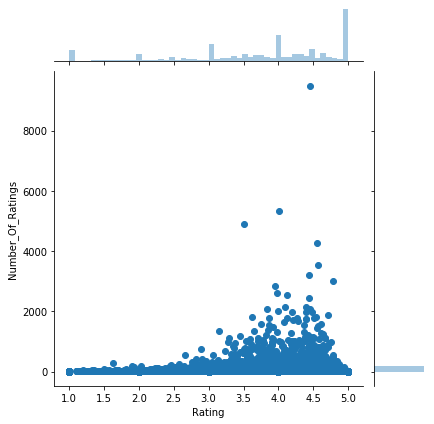

In [137]:
sns.jointplot(ratings.Rating,ratings.Number_Of_Ratings)

No great co-relation is noticed. But it is noticeable that products with lower ratings have lesser number of users rating it.

In [138]:
counts=df.userID.value_counts()
counts.sort_values(ascending=True).head()

A8L117I4C48VF     1
ACDI6ENDNMQ1P     1
A1WH7GQMQR9W90    1
A3KR0MTIQAQZS8    1
A33983PECRE8SS    1
Name: userID, dtype: int64

Seems like there a lot of users who have provided very few ratings. Considering the entries from these users may not contribute much to the recommendation system we want to build, we may drop all users who have rated less than 25 times

In [139]:
df=df[df['userID'].isin(counts[counts >= 25].index)]
df.shape

(9549, 4)

In [140]:
df.tail()

,userID,productID,Rating,timestamp
1046783,ARBKYIVNYWK3C,B000IE8Z4Q,4,1243123200
1047254,A3REK3OFONWB1Q,B000IEVASY,5,1283126400
1047943,AWPODHOB4GFWL,B000IF4788,4,1194480000
1048157,A2XRMQA6PJ5ZJ8,B000IF4788,4,1342483200
1048513,A3CW0ZLUO5X2B1,B000IF51UQ,4,1377129600


Text(0.5, 1.0, 'Distribution of Ratings')

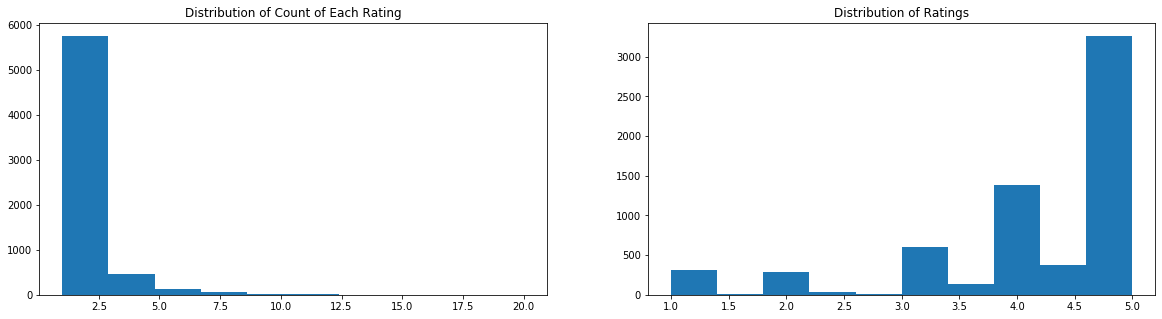

In [141]:
ratings=pd.DataFrame(df.groupby('productID')['Rating'].mean())
ratings['Number_Of_Ratings']=pd.DataFrame(df.groupby('productID')['Rating'].count())

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.hist(ratings.Number_Of_Ratings)
plt.title('Distribution of Count of Each Rating')

plt.subplot(1,2,2)
plt.hist(ratings.Rating)
plt.title('Distribution of Ratings')

#This looks a much better distribution than before, with very high proportion of people having rated products as 4 or 5. However most of the products seem to have been rated only once or twice.

In [142]:
ratings.Number_Of_Ratings.value_counts(normalize=True)

1     0.758766
2     0.138694
3     0.050335
4     0.020259
5     0.011999
6     0.006701
7     0.005298
8     0.002805
9     0.001714
11    0.000935
10    0.000623
12    0.000468
18    0.000312
14    0.000312
16    0.000156
15    0.000156
20    0.000156
13    0.000156
17    0.000156
Name: Number_Of_Ratings, dtype: float64

In [143]:
counts=df.userID.value_counts()
counts.sort_values(ascending=True).head()

A3MV1KKHX51FYT    25
A3KTWUXXB8KKC7    25
A1S3FOP19D8W1X    25
A1L64KDYO5BOJA    25
A3DQWFWINN3V5A    25
Name: userID, dtype: int64

In [144]:
#converting the dataframe to format supported by surprise package


from surprise import Reader, Dataset
reader = Reader()
data = Dataset.load_from_df(df[['userID', 'productID', 'Rating']], reader)

In [145]:
trainset, testset = train_test_split(data, test_size=0.25)

In [146]:
from surprise import SVD, accuracy
algo = SVD()
algo.fit(trainset)

predictions = algo.test(testset)

In [147]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 1.0742


1.0742388291328926

In [148]:
results=pd.DataFrame({'SVD':[1.741]}, index=['RMSE'])
results

,SVD
RMSE,1.741


In [149]:
from collections import defaultdict
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [150]:
#Top 5 recommendations per user is below (alongwith the ratings of those products)

In [151]:
top_n = get_top_n(predictions, n=5)
top_n

defaultdict(list,
            {'A1N2D7LLBAY25B': [('B00006IS9M', 3.300639692381011),
              ('B0000510SS', 3.1706843091754426),
              ('B00008KWWF', 3.1706843091754426),
              ('B00000JDH5', 3.1706843091754426),
              ('B000FNS52M', 3.1706843091754426)],
             'A11D1KHM7DVOQK': [('B000BP50AY', 3.460050731222234),
              ('B00008ZPNR', 3.329935321129652),
              ('B0000E1717', 3.3248132959610768),
              ('B0002RRVQW', 3.312059860070778),
              ('B0002SQ3Z6', 3.2392576670794413)],
             'AHROSV6WJOEGY': [('B00006I53S', 3.66528806174349),
              ('B000EPJL1A', 3.567162244710953),
              ('B0002GDIII', 3.5653127992851297),
              ('B0007NWM10', 3.5470062935793765),
              ('B0007W2H2K', 3.5470062935793765)],
             'A1F9Z42CFF9IAY': [('B000I1YIDQ', 3.922311160849016),
              ('B00009RUCH', 3.8798167860184725),
              ('B00006HCCK', 3.7834895868653575),
              ('

In [152]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1N2D7LLBAY25B ['B00006IS9M', 'B0000510SS', 'B00008KWWF', 'B00000JDH5', 'B000FNS52M']
A11D1KHM7DVOQK ['B000BP50AY', 'B00008ZPNR', 'B0000E1717', 'B0002RRVQW', 'B0002SQ3Z6']
AHROSV6WJOEGY ['B00006I53S', 'B000EPJL1A', 'B0002GDIII', 'B0007NWM10', 'B0007W2H2K']
A1F9Z42CFF9IAY ['B000I1YIDQ', 'B00009RUCH', 'B00006HCCK', 'B000AJIF4E', 'B00009R6WT']
AD8DLOGHAXL ['B00005T6GZ', 'B00006HSF1', 'B00007IFDT', 'B00007L3NJ', 'B000H51GA6']
A2ZR3YTMEEIIZ4 ['B0000DZET4', 'B0007KX4TC', 'B0001HAFAW', 'B00065ZK3G', 'B0008D7B6U']
ASCM3206SVTO0 ['B00008OE6I', 'B00005Q7DG', 'B0002KQR28', 'B00006JLOT', 'B0001D3K8A']
A32O5FZH994CNY ['B000HGIWN4', 'B00006AVV3', 'B000067DKI', 'B0009IQ62Y', 'B000EEXEIW']
AT2J7H5TRZM8Z ['B00006LV79', 'B00005QFZG', 'B00004VWM3', 'B000031KIM', 'B000065V15']
ABH9D1TEOJ56E ['B000087HWM', 'B0000C4E4S', 'B0000C2W57', 'B00008N6RV', 'B000093UU4']
A231WM2Z2JL0U3 ['B00008OE6I', 'B00005B6UF', 'B00004TDL2', 'B00005OMZT', 'B00006LV79']
A15QYHQH80W30L ['B00015GYU4', 'B0007W1E4W', 'B00005LE73', 'B0

In [153]:
#Grid Search

param_grid = {
    "n_epochs": [10,15,20,25],
    "lr_all": [0.02,0.03,0.04,0.05],
    "reg_all": [0.03,0.04,0.05,0.6]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

1.0608624755872673
{'n_epochs': 10, 'lr_all': 0.02, 'reg_all': 0.05}


In [154]:
algo = SVD(n_epochs= 25, lr_all=0.04, reg_all=0.03)
algo.fit(trainset)

predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 1.0773


1.0773384635081213

In [155]:
results['SVD_tuned']=[1.0820]
results

,SVD,SVD_tuned
RMSE,1.741,1.082


In [156]:
#Top 5 recommendations per user is below

top_n = get_top_n(predictions, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1N2D7LLBAY25B ['B00006IS9M', 'B0000510SS', 'B00008KWWF', 'B00000JDH5', 'B000FNS52M']
A11D1KHM7DVOQK ['B00009L1RI', 'B00008VIX2', 'B000BP50AY', 'B0000E1717', 'B00008ZPNR']
AHROSV6WJOEGY ['B00006HYP6', 'B0002GDIII', 'B000EPJL1A', 'B0007NWM10', 'B0007W2H2K']
A1F9Z42CFF9IAY ['B00009R6WT', 'B000I1YIDQ', 'B0002QWU3W', 'B00009KAPW', 'B000AJIF4E']
AD8DLOGHAXL ['B00005T6GZ', 'B00006HSF1', 'B00007IFDT', 'B00007L3NJ', 'B000H51GA6']
A2ZR3YTMEEIIZ4 ['B0007KX4TC', 'B0000DZET4', 'B0001HAFAW', 'B00065ZK3G', 'B0008D7B6U']
ASCM3206SVTO0 ['B00008OE6I', 'B0000C8817', 'B00005Q7DG', 'B00005MEN6', 'B0002KQR28']
A32O5FZH994CNY ['B000HGIWN4', 'B000087KY5', 'B00006AVV3', 'B000067DKI', 'B0009IQ62Y']
AT2J7H5TRZM8Z ['B00006LV79', 'B000065V15', 'B000031KIM', 'B000056SSM', 'B000067BEG']
ABH9D1TEOJ56E ['B0000C4E4S', 'B000087HWM', 'B0000C2W57', 'B00008N6RV', 'B000093UU4']
A231WM2Z2JL0U3 ['B00006LV79', 'B00008J639', 'B00008OE6I', 'B00008IHU2', 'B00004TDL2']
A15QYHQH80W30L ['B00005LE73', 'B0007MGG2M', 'B0007W1E4W', 'B0

In [157]:
# Collaborative filtering

In [158]:
from surprise import KNNWithMeans
algo = KNNWithMeans(k=25, sim_options={'name': 'cosine', 'user_based': True})
algo.fit(trainset)
test_pred = algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [159]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.1645


1.1645461095766565

In [160]:
results['User-User_CF']=[1.17839]
results

,SVD,SVD_tuned,User-User_CF
RMSE,1.741,1.082,1.17839


In [161]:
#Top 5 recommendations per user is below

top_n = get_top_n(test_pred, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1N2D7LLBAY25B ['B0000510SS', 'B00008KWWF', 'B00000JDH5', 'B000FNS52M', 'B000FPF9DI']
A11D1KHM7DVOQK ['B000BP50AY', 'B0000DFHMM', 'B00006HMPZ', 'B00008V6JO', 'B000083K05']
AHROSV6WJOEGY ['B0007NWM10', 'B0007W2H2K', 'B000E7GDUK', 'B00009KO0D', 'B000067TGV']
A1F9Z42CFF9IAY ['B000AJIF4E', 'B00009R6WT', 'B000I1YIDQ', 'B00006HCCK', 'B0002ILKNQ']
AD8DLOGHAXL ['B000H51GA6', 'B00005T6GZ', 'B00006HSF1', 'B00007IFDT', 'B00007L3NJ']
A2ZR3YTMEEIIZ4 ['B0001HAFAW', 'B00065ZK3G', 'B0008D7B6U', 'B0009IU4OA', 'B00007KJTT']
ASCM3206SVTO0 ['B00008OE6I', 'B0000C8817', 'B0001D3K8A', 'B00005B6UF', 'B00005MEN6']
A32O5FZH994CNY ['B000B6D39I', 'B000HGIWN4', 'B000FZXHGO', 'B000087KY5', 'B00005B4BW']
AT2J7H5TRZM8Z ['B000065V15', 'B000031KIM', 'B000068BRE', 'B00005QFZG', 'B00005T3V9']
ABH9D1TEOJ56E ['B0000C4E4S', 'B000087HWM', 'B0000C2W57', 'B00008N6RV', 'B000093UU4']
A231WM2Z2JL0U3 ['B00004S9AK', 'B00004TS16', 'B00005OMZT', 'B00006LV79', 'B000051123']
A15QYHQH80W30L ['B00005LE73', 'B00015GYU4', 'B00009UTCD', 'B0

In [162]:
# Let's tune the model and see if we can get better results

sim_options = {
    "name": ["msd", "cosine", "pearson_baseline"],
        "min_support": [25,50,75],
    "user_based": [True],
}

param_grid = {"sim_options": sim_options}

gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse"], cv=3)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

In [163]:
algo = KNNWithMeans(k=25, sim_options={'name': 'msd', 'user_based': True})
algo.fit(trainset)
test_pred = algo.test(testset)
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
User-based Model : Test Set
RMSE: 1.1629


1.1629207558691834

In [164]:
results['Use-User_CF_Tuned']=[1.17797]
results

,SVD,SVD_tuned,User-User_CF,Use-User_CF_Tuned
RMSE,1.741,1.082,1.17839,1.17797


In [165]:
#Top 5 recommendations per user is below

top_n = get_top_n(test_pred, n=5)
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A1N2D7LLBAY25B ['B0000510SS', 'B00008KWWF', 'B00000JDH5', 'B000FNS52M', 'B000FPF9DI']
A11D1KHM7DVOQK ['B000BP50AY', 'B0000DFHMM', 'B00006HMPZ', 'B00008V6JO', 'B000083K05']
AHROSV6WJOEGY ['B0007NWM10', 'B0007W2H2K', 'B000E7GDUK', 'B00009KO0D', 'B000067TGV']
A1F9Z42CFF9IAY ['B000AJIF4E', 'B000I1YIDQ', 'B00009R6WT', 'B00006HCCK', 'B0002ILKNQ']
AD8DLOGHAXL ['B000H51GA6', 'B00005T6GZ', 'B00006HSF1', 'B00007IFDT', 'B00007L3NJ']
A2ZR3YTMEEIIZ4 ['B0001HAFAW', 'B00065ZK3G', 'B0008D7B6U', 'B0009IU4OA', 'B00007KJTT']
ASCM3206SVTO0 ['B00008OE6I', 'B0000C8817', 'B0001D3K8A', 'B00005B6UF', 'B00005MEN6']
A32O5FZH994CNY ['B000B6D39I', 'B000HGIWN4', 'B000FZXHGO', 'B000087KY5', 'B00005B4BW']
AT2J7H5TRZM8Z ['B000065V15', 'B000031KIM', 'B000068BRE', 'B00005QFZG', 'B00005T3V9']
ABH9D1TEOJ56E ['B0000C4E4S', 'B000087HWM', 'B0000C2W57', 'B00008N6RV', 'B000093UU4']
A231WM2Z2JL0U3 ['B00004TS16', 'B00005OMZT', 'B000051123', 'B00006JHTQ', 'B00004S9AK']
A15QYHQH80W30L ['B00005LE73', 'B00015GYU4', 'B00009UTCD', 'B0

In [166]:
#Try Matrix based and svd for recorrelations based on correlation

In [167]:
#Generate matrix table

ratings_matrix = df.pivot(index='userID', columns='productID', values='Rating').fillna(0)
userID = ratings_matrix.index
ProductID = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(226, 6417)


productID,1400532655,1400599997,1685560148,787988002X,9043413585,970407998,9981719005,998376234X,9985734459,B000000O2F,...,B000ID6DTG,B000ID7QNI,B000IDCDZY,B000IDWDKO,B000IE1KZC,B000IE5XIC,B000IE8Z4Q,B000IEVASY,B000IF4788,B000IF51UQ
userID,,,,,,,,,,,,,,,,,,,,,
A11D1KHM7DVOQK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11ED8O95W2103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11EYMH9UV9XG7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A11KZ906QD08C5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DLJESJKM1OQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


since NaNs cannot be handled by training algos, replacing these by 0, which indicates absence of ratings

In [168]:
ratings.sort_values('Number_Of_Ratings', ascending=False).head(20)

,Rating,Number_Of_Ratings
productID,,
B00007KDVI,3.500000,20
B00007E7JU,4.555556,18
B00004ZCJE,4.444444,18
B00004SB92,4.470588,17
B00005LEN4,4.687500,16
B0007QKMQY,4.733333,15
B000AZ57M6,4.642857,14
B00009XVCZ,4.714286,14
B00008OE6I,4.769231,13


In [169]:
#Lets choose product 1400532655 and store its tarings in a series

ProdID_ratings=ratings_matrix['B00007E7JU']

In [170]:
#We can find the correlation between this and matrix with all product ratings
Similar_to_prod_rating=ratings_matrix.corrwith(ProdID_ratings)

In [171]:
# For Product with ID=B00007E7JU, the 10 products that will be recommended are given above 

In [172]:
cor_with_prod=pd.DataFrame(Similar_to_prod_rating,columns=['Corelation']).sort_values('Corelation', ascending=False)
cor_with_prod.head(11)

,Corelation
productID,
B00007E7JU,1.000000
B0009JO2YC,0.349981
B00005T3N0,0.347821
B000DZDTKU,0.336350
B000HATNI8,0.312245
B0000A0AEM,0.311992
B0000A1G05,0.305735
B00004YZQ8,0.295726
B00009U0XI,0.295726


In [173]:
df.columns

Index(['userID', 'productID', 'Rating', 'timestamp'], dtype='object')

In [174]:
# Popularity based reccomendation
df.groupby('productID')['Rating'].mean().head()

productID
1400532655    3.0
1400599997    1.0
1685560148    5.0
787988002X    5.0
9043413585    3.0
Name: Rating, dtype: float64

In [175]:
df.groupby('productID')['Rating'].mean().sort_values(ascending=False).head()

productID
B00016USAA    5.0
B000067VKY    5.0
B0002J2TLC    5.0
B0002J2P1Q    5.0
B0002J2O26    5.0
Name: Rating, dtype: float64

In [176]:
df.groupby('productID')['Rating'].count().sort_values(ascending=False).head()  

productID
B00007KDVI    20
B00004ZCJE    18
B00007E7JU    18
B00004SB92    17
B00005LEN4    16
Name: Rating, dtype: int64

In [177]:
ratings_mean_count = pd.DataFrame(df.groupby('productID')['Rating'].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('productID')['Rating'].count())
ratings_mean_count.head()

,Rating,rating_counts
productID,,
1400532655,3.0,2
1400599997,1.0,1
1685560148,5.0,1
787988002X,5.0,1
9043413585,3.0,1


In [178]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size = 0.20, random_state=0)
train_data.head()

,userID,productID,Rating,timestamp
351260,A6FIAB28IS79,B0000TQ154,3,1194393600
339751,A231WM2Z2JL0U3,B0000CEOYI,5,1068940800
109052,A231WM2Z2JL0U3,B00005NDUP,5,1025308800
64062,A3MEIR72XKQY88,B00004YV8E,4,976320000
666847,A3W4D8XOGLWUN5,B0009JB7P4,5,1161388800


In [179]:
#Count of user_id for each unique song as recommendation score 
train_data_grouped = train_data.groupby('productID').agg({'userID': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userID': 'score'},inplace=True)
train_data_grouped.head()

,productID,score
0,1400532655,2
1,1400599997,1
2,1685560148,1
3,787988002X,1
4,9043413585,1


In [180]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productID'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,productID,score,Rank
1662,B00007E7JU,17,1.0
1724,B00007KDVI,17,2.0
772,B00005LEN4,14,3.0
262,B00004SB92,13,4.0
549,B00004ZCJE,13,5.0


In [181]:
# Recommendations for any random user using the model

# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userID'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [182]:
test_data.head()

,userID,productID,Rating,timestamp
64164,A2BGZ52M908MJY,B00004YZLV,4,987465600
443086,A31N0XY2UTB25C,B00029U1DK,5,1331424000
60584,A8TZ88OM8YOLW,B00004X0ZH,5,1035676800
130474,A14ME4FQBNFYWH,B000062STU,5,1042675200
576841,A2BCDZO1XQLDH,B0006VYGRG,4,1114560000


In [183]:
test_data.index

Int64Index([ 64164, 443086,  60584, 130474, 576841, 578661, 883070, 342931,
            196904,  47460,
            ...
            304579, 159428, 332798, 343764, 338287, 461481, 134884, 633824,
             70369,  64421],
           dtype='int64', length=1910)

In [184]:
find_recom = test_data.index   # This list is user choice.
for i in find_recom:
    
    print(recommend(i))    
    print("\n") 

      userID   productID  score  Rank
1662   64164  B00007E7JU     17   1.0
1724   64164  B00007KDVI     17   2.0
772    64164  B00005LEN4     14   3.0
262    64164  B00004SB92     13   4.0
549    64164  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  443086  B00007E7JU     17   1.0
1724  443086  B00007KDVI     17   2.0
772   443086  B00005LEN4     14   3.0
262   443086  B00004SB92     13   4.0
549   443086  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   60584  B00007E7JU     17   1.0
1724   60584  B00007KDVI     17   2.0
772    60584  B00005LEN4     14   3.0
262    60584  B00004SB92     13   4.0
549    60584  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  130474  B00007E7JU     17   1.0
1724  130474  B00007KDVI     17   2.0
772   130474  B00005LEN4     14   3.0
262   130474  B00004SB92     13   4.0
549   130474  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  576841  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  566240  B00007E7JU     17   1.0
1724  566240  B00007KDVI     17   2.0
772   566240  B00005LEN4     14   3.0
262   566240  B00004SB92     13   4.0
549   566240  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  131694  B00007E7JU     17   1.0
1724  131694  B00007KDVI     17   2.0
772   131694  B00005LEN4     14   3.0
262   131694  B00004SB92     13   4.0
549   131694  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   19485  B00007E7JU     17   1.0
1724   19485  B00007KDVI     17   2.0
772    19485  B00005LEN4     14   3.0
262    19485  B00004SB92     13   4.0
549    19485  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  297875  B00007E7JU     17   1.0
1724  297875  B00007KDVI     17   2.0
772   297875  B00005LEN4     14   3.0
262   297875  B00004SB92     13   4.0
549   297875  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   85045  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   14335  B00007E7JU     17   1.0
1724   14335  B00007KDVI     17   2.0
772    14335  B00005LEN4     14   3.0
262    14335  B00004SB92     13   4.0
549    14335  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  885956  B00007E7JU     17   1.0
1724  885956  B00007KDVI     17   2.0
772   885956  B00005LEN4     14   3.0
262   885956  B00004SB92     13   4.0
549   885956  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  333171  B00007E7JU     17   1.0
1724  333171  B00007KDVI     17   2.0
772   333171  B00005LEN4     14   3.0
262   333171  B00004SB92     13   4.0
549   333171  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  590541  B00007E7JU     17   1.0
1724  590541  B00007KDVI     17   2.0
772   590541  B00005LEN4     14   3.0
262   590541  B00004SB92     13   4.0
549   590541  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  868396  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  758915  B00007E7JU     17   1.0
1724  758915  B00007KDVI     17   2.0
772   758915  B00005LEN4     14   3.0
262   758915  B00004SB92     13   4.0
549   758915  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   95060  B00007E7JU     17   1.0
1724   95060  B00007KDVI     17   2.0
772    95060  B00005LEN4     14   3.0
262    95060  B00004SB92     13   4.0
549    95060  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  648268  B00007E7JU     17   1.0
1724  648268  B00007KDVI     17   2.0
772   648268  B00005LEN4     14   3.0
262   648268  B00004SB92     13   4.0
549   648268  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  119732  B00007E7JU     17   1.0
1724  119732  B00007KDVI     17   2.0
772   119732  B00005LEN4     14   3.0
262   119732  B00004SB92     13   4.0
549   119732  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  400404  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   43677  B00007E7JU     17   1.0
1724   43677  B00007KDVI     17   2.0
772    43677  B00005LEN4     14   3.0
262    43677  B00004SB92     13   4.0
549    43677  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  285882  B00007E7JU     17   1.0
1724  285882  B00007KDVI     17   2.0
772   285882  B00005LEN4     14   3.0
262   285882  B00004SB92     13   4.0
549   285882  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   91636  B00007E7JU     17   1.0
1724   91636  B00007KDVI     17   2.0
772    91636  B00005LEN4     14   3.0
262    91636  B00004SB92     13   4.0
549    91636  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  625831  B00007E7JU     17   1.0
1724  625831  B00007KDVI     17   2.0
772   625831  B00005LEN4     14   3.0
262   625831  B00004SB92     13   4.0
549   625831  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  530729  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  189728  B00007E7JU     17   1.0
1724  189728  B00007KDVI     17   2.0
772   189728  B00005LEN4     14   3.0
262   189728  B00004SB92     13   4.0
549   189728  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  767676  B00007E7JU     17   1.0
1724  767676  B00007KDVI     17   2.0
772   767676  B00005LEN4     14   3.0
262   767676  B00004SB92     13   4.0
549   767676  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  842541  B00007E7JU     17   1.0
1724  842541  B00007KDVI     17   2.0
772   842541  B00005LEN4     14   3.0
262   842541  B00004SB92     13   4.0
549   842541  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  517329  B00007E7JU     17   1.0
1724  517329  B00007KDVI     17   2.0
772   517329  B00005LEN4     14   3.0
262   517329  B00004SB92     13   4.0
549   517329  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  116808  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  157835  B00007E7JU     17   1.0
1724  157835  B00007KDVI     17   2.0
772   157835  B00005LEN4     14   3.0
262   157835  B00004SB92     13   4.0
549   157835  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  238429  B00007E7JU     17   1.0
1724  238429  B00007KDVI     17   2.0
772   238429  B00005LEN4     14   3.0
262   238429  B00004SB92     13   4.0
549   238429  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  969264  B00007E7JU     17   1.0
1724  969264  B00007KDVI     17   2.0
772   969264  B00005LEN4     14   3.0
262   969264  B00004SB92     13   4.0
549   969264  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  190087  B00007E7JU     17   1.0
1724  190087  B00007KDVI     17   2.0
772   190087  B00005LEN4     14   3.0
262   190087  B00004SB92     13   4.0
549   190087  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  157857  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  251925  B00007E7JU     17   1.0
1724  251925  B00007KDVI     17   2.0
772   251925  B00005LEN4     14   3.0
262   251925  B00004SB92     13   4.0
549   251925  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  382477  B00007E7JU     17   1.0
1724  382477  B00007KDVI     17   2.0
772   382477  B00005LEN4     14   3.0
262   382477  B00004SB92     13   4.0
549   382477  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  305333  B00007E7JU     17   1.0
1724  305333  B00007KDVI     17   2.0
772   305333  B00005LEN4     14   3.0
262   305333  B00004SB92     13   4.0
549   305333  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  339668  B00007E7JU     17   1.0
1724  339668  B00007KDVI     17   2.0
772   339668  B00005LEN4     14   3.0
262   339668  B00004SB92     13   4.0
549   339668  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  274234  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  510134  B00007E7JU     17   1.0
1724  510134  B00007KDVI     17   2.0
772   510134  B00005LEN4     14   3.0
262   510134  B00004SB92     13   4.0
549   510134  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1003178  B00007E7JU     17   1.0
1724  1003178  B00007KDVI     17   2.0
772   1003178  B00005LEN4     14   3.0
262   1003178  B00004SB92     13   4.0
549   1003178  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  937213  B00007E7JU     17   1.0
1724  937213  B00007KDVI     17   2.0
772   937213  B00005LEN4     14   3.0
262   937213  B00004SB92     13   4.0
549   937213  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  701086  B00007E7JU     17   1.0
1724  701086  B00007KDVI     17   2.0
772   701086  B00005LEN4     14   3.0
262   701086  B00004SB92     13   4.0
549   701086  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  324960  B00007E7JU     17   1.

      userID   productID  score  Rank
1662  528018  B00007E7JU     17   1.0
1724  528018  B00007KDVI     17   2.0
772   528018  B00005LEN4     14   3.0
262   528018  B00004SB92     13   4.0
549   528018  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662    8105  B00007E7JU     17   1.0
1724    8105  B00007KDVI     17   2.0
772     8105  B00005LEN4     14   3.0
262     8105  B00004SB92     13   4.0
549     8105  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  631988  B00007E7JU     17   1.0
1724  631988  B00007KDVI     17   2.0
772   631988  B00005LEN4     14   3.0
262   631988  B00004SB92     13   4.0
549   631988  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  128757  B00007E7JU     17   1.0
1724  128757  B00007KDVI     17   2.0
772   128757  B00005LEN4     14   3.0
262   128757  B00004SB92     13   4.0
549   128757  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  160510  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  410139  B00007E7JU     17   1.0
1724  410139  B00007KDVI     17   2.0
772   410139  B00005LEN4     14   3.0
262   410139  B00004SB92     13   4.0
549   410139  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  121906  B00007E7JU     17   1.0
1724  121906  B00007KDVI     17   2.0
772   121906  B00005LEN4     14   3.0
262   121906  B00004SB92     13   4.0
549   121906  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   59144  B00007E7JU     17   1.0
1724   59144  B00007KDVI     17   2.0
772    59144  B00005LEN4     14   3.0
262    59144  B00004SB92     13   4.0
549    59144  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  922029  B00007E7JU     17   1.0
1724  922029  B00007KDVI     17   2.0
772   922029  B00005LEN4     14   3.0
262   922029  B00004SB92     13   4.0
549   922029  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  548252  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  261778  B00007E7JU     17   1.0
1724  261778  B00007KDVI     17   2.0
772   261778  B00005LEN4     14   3.0
262   261778  B00004SB92     13   4.0
549   261778  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  333762  B00007E7JU     17   1.0
1724  333762  B00007KDVI     17   2.0
772   333762  B00005LEN4     14   3.0
262   333762  B00004SB92     13   4.0
549   333762  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  523048  B00007E7JU     17   1.0
1724  523048  B00007KDVI     17   2.0
772   523048  B00005LEN4     14   3.0
262   523048  B00004SB92     13   4.0
549   523048  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  333729  B00007E7JU     17   1.0
1724  333729  B00007KDVI     17   2.0
772   333729  B00005LEN4     14   3.0
262   333729  B00004SB92     13   4.0
549   333729  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  395385  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  872691  B00007E7JU     17   1.0
1724  872691  B00007KDVI     17   2.0
772   872691  B00005LEN4     14   3.0
262   872691  B00004SB92     13   4.0
549   872691  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  638803  B00007E7JU     17   1.0
1724  638803  B00007KDVI     17   2.0
772   638803  B00005LEN4     14   3.0
262   638803  B00004SB92     13   4.0
549   638803  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   91539  B00007E7JU     17   1.0
1724   91539  B00007KDVI     17   2.0
772    91539  B00005LEN4     14   3.0
262    91539  B00004SB92     13   4.0
549    91539  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  245207  B00007E7JU     17   1.0
1724  245207  B00007KDVI     17   2.0
772   245207  B00005LEN4     14   3.0
262   245207  B00004SB92     13   4.0
549   245207  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  353491  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  243155  B00007E7JU     17   1.0
1724  243155  B00007KDVI     17   2.0
772   243155  B00005LEN4     14   3.0
262   243155  B00004SB92     13   4.0
549   243155  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  241474  B00007E7JU     17   1.0
1724  241474  B00007KDVI     17   2.0
772   241474  B00005LEN4     14   3.0
262   241474  B00004SB92     13   4.0
549   241474  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  857719  B00007E7JU     17   1.0
1724  857719  B00007KDVI     17   2.0
772   857719  B00005LEN4     14   3.0
262   857719  B00004SB92     13   4.0
549   857719  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  250946  B00007E7JU     17   1.0
1724  250946  B00007KDVI     17   2.0
772   250946  B00005LEN4     14   3.0
262   250946  B00004SB92     13   4.0
549   250946  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  735839  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  104307  B00007E7JU     17   1.0
1724  104307  B00007KDVI     17   2.0
772   104307  B00005LEN4     14   3.0
262   104307  B00004SB92     13   4.0
549   104307  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   24871  B00007E7JU     17   1.0
1724   24871  B00007KDVI     17   2.0
772    24871  B00005LEN4     14   3.0
262    24871  B00004SB92     13   4.0
549    24871  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  247753  B00007E7JU     17   1.0
1724  247753  B00007KDVI     17   2.0
772   247753  B00005LEN4     14   3.0
262   247753  B00004SB92     13   4.0
549   247753  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  779340  B00007E7JU     17   1.0
1724  779340  B00007KDVI     17   2.0
772   779340  B00005LEN4     14   3.0
262   779340  B00004SB92     13   4.0
549   779340  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  256181  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  527909  B00007E7JU     17   1.0
1724  527909  B00007KDVI     17   2.0
772   527909  B00005LEN4     14   3.0
262   527909  B00004SB92     13   4.0
549   527909  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  365214  B00007E7JU     17   1.0
1724  365214  B00007KDVI     17   2.0
772   365214  B00005LEN4     14   3.0
262   365214  B00004SB92     13   4.0
549   365214  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  252505  B00007E7JU     17   1.0
1724  252505  B00007KDVI     17   2.0
772   252505  B00005LEN4     14   3.0
262   252505  B00004SB92     13   4.0
549   252505  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  305028  B00007E7JU     17   1.0
1724  305028  B00007KDVI     17   2.0
772   305028  B00005LEN4     14   3.0
262   305028  B00004SB92     13   4.0
549   305028  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  103042  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  630049  B00007E7JU     17   1.0
1724  630049  B00007KDVI     17   2.0
772   630049  B00005LEN4     14   3.0
262   630049  B00004SB92     13   4.0
549   630049  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1006972  B00007E7JU     17   1.0
1724  1006972  B00007KDVI     17   2.0
772   1006972  B00005LEN4     14   3.0
262   1006972  B00004SB92     13   4.0
549   1006972  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  353876  B00007E7JU     17   1.0
1724  353876  B00007KDVI     17   2.0
772   353876  B00005LEN4     14   3.0
262   353876  B00004SB92     13   4.0
549   353876  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  935541  B00007E7JU     17   1.0
1724  935541  B00007KDVI     17   2.0
772   935541  B00005LEN4     14   3.0
262   935541  B00004SB92     13   4.0
549   935541  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   15792  B00007E7JU     17   1.

      userID   productID  score  Rank
1662  821454  B00007E7JU     17   1.0
1724  821454  B00007KDVI     17   2.0
772   821454  B00005LEN4     14   3.0
262   821454  B00004SB92     13   4.0
549   821454  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  324099  B00007E7JU     17   1.0
1724  324099  B00007KDVI     17   2.0
772   324099  B00005LEN4     14   3.0
262   324099  B00004SB92     13   4.0
549   324099  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  364614  B00007E7JU     17   1.0
1724  364614  B00007KDVI     17   2.0
772   364614  B00005LEN4     14   3.0
262   364614  B00004SB92     13   4.0
549   364614  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   43120  B00007E7JU     17   1.0
1724   43120  B00007KDVI     17   2.0
772    43120  B00005LEN4     14   3.0
262    43120  B00004SB92     13   4.0
549    43120  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  891764  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  282583  B00007E7JU     17   1.0
1724  282583  B00007KDVI     17   2.0
772   282583  B00005LEN4     14   3.0
262   282583  B00004SB92     13   4.0
549   282583  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  831464  B00007E7JU     17   1.0
1724  831464  B00007KDVI     17   2.0
772   831464  B00005LEN4     14   3.0
262   831464  B00004SB92     13   4.0
549   831464  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  232489  B00007E7JU     17   1.0
1724  232489  B00007KDVI     17   2.0
772   232489  B00005LEN4     14   3.0
262   232489  B00004SB92     13   4.0
549   232489  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1018793  B00007E7JU     17   1.0
1724  1018793  B00007KDVI     17   2.0
772   1018793  B00005LEN4     14   3.0
262   1018793  B00004SB92     13   4.0
549   1018793  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  934323  B00007E7JU     17   1.

      userID   productID  score  Rank
1662  113573  B00007E7JU     17   1.0
1724  113573  B00007KDVI     17   2.0
772   113573  B00005LEN4     14   3.0
262   113573  B00004SB92     13   4.0
549   113573  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1014287  B00007E7JU     17   1.0
1724  1014287  B00007KDVI     17   2.0
772   1014287  B00005LEN4     14   3.0
262   1014287  B00004SB92     13   4.0
549   1014287  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  576095  B00007E7JU     17   1.0
1724  576095  B00007KDVI     17   2.0
772   576095  B00005LEN4     14   3.0
262   576095  B00004SB92     13   4.0
549   576095  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  273900  B00007E7JU     17   1.0
1724  273900  B00007KDVI     17   2.0
772   273900  B00005LEN4     14   3.0
262   273900  B00004SB92     13   4.0
549   273900  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  447656  B00007E7JU     17   1.

      userID   productID  score  Rank
1662  809459  B00007E7JU     17   1.0
1724  809459  B00007KDVI     17   2.0
772   809459  B00005LEN4     14   3.0
262   809459  B00004SB92     13   4.0
549   809459  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  286669  B00007E7JU     17   1.0
1724  286669  B00007KDVI     17   2.0
772   286669  B00005LEN4     14   3.0
262   286669  B00004SB92     13   4.0
549   286669  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  462042  B00007E7JU     17   1.0
1724  462042  B00007KDVI     17   2.0
772   462042  B00005LEN4     14   3.0
262   462042  B00004SB92     13   4.0
549   462042  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  554060  B00007E7JU     17   1.0
1724  554060  B00007KDVI     17   2.0
772   554060  B00005LEN4     14   3.0
262   554060  B00004SB92     13   4.0
549   554060  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   36223  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  695361  B00007E7JU     17   1.0
1724  695361  B00007KDVI     17   2.0
772   695361  B00005LEN4     14   3.0
262   695361  B00004SB92     13   4.0
549   695361  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  187725  B00007E7JU     17   1.0
1724  187725  B00007KDVI     17   2.0
772   187725  B00005LEN4     14   3.0
262   187725  B00004SB92     13   4.0
549   187725  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  823850  B00007E7JU     17   1.0
1724  823850  B00007KDVI     17   2.0
772   823850  B00005LEN4     14   3.0
262   823850  B00004SB92     13   4.0
549   823850  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  925227  B00007E7JU     17   1.0
1724  925227  B00007KDVI     17   2.0
772   925227  B00005LEN4     14   3.0
262   925227  B00004SB92     13   4.0
549   925227  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  341431  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  304725  B00007E7JU     17   1.0
1724  304725  B00007KDVI     17   2.0
772   304725  B00005LEN4     14   3.0
262   304725  B00004SB92     13   4.0
549   304725  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  725155  B00007E7JU     17   1.0
1724  725155  B00007KDVI     17   2.0
772   725155  B00005LEN4     14   3.0
262   725155  B00004SB92     13   4.0
549   725155  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  460115  B00007E7JU     17   1.0
1724  460115  B00007KDVI     17   2.0
772   460115  B00005LEN4     14   3.0
262   460115  B00004SB92     13   4.0
549   460115  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  660844  B00007E7JU     17   1.0
1724  660844  B00007KDVI     17   2.0
772   660844  B00005LEN4     14   3.0
262   660844  B00004SB92     13   4.0
549   660844  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  255189  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  396396  B00007E7JU     17   1.0
1724  396396  B00007KDVI     17   2.0
772   396396  B00005LEN4     14   3.0
262   396396  B00004SB92     13   4.0
549   396396  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  839668  B00007E7JU     17   1.0
1724  839668  B00007KDVI     17   2.0
772   839668  B00005LEN4     14   3.0
262   839668  B00004SB92     13   4.0
549   839668  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  990225  B00007E7JU     17   1.0
1724  990225  B00007KDVI     17   2.0
772   990225  B00005LEN4     14   3.0
262   990225  B00004SB92     13   4.0
549   990225  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  344879  B00007E7JU     17   1.0
1724  344879  B00007KDVI     17   2.0
772   344879  B00005LEN4     14   3.0
262   344879  B00004SB92     13   4.0
549   344879  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  856360  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  107010  B00007E7JU     17   1.0
1724  107010  B00007KDVI     17   2.0
772   107010  B00005LEN4     14   3.0
262   107010  B00004SB92     13   4.0
549   107010  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  599202  B00007E7JU     17   1.0
1724  599202  B00007KDVI     17   2.0
772   599202  B00005LEN4     14   3.0
262   599202  B00004SB92     13   4.0
549   599202  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   74054  B00007E7JU     17   1.0
1724   74054  B00007KDVI     17   2.0
772    74054  B00005LEN4     14   3.0
262    74054  B00004SB92     13   4.0
549    74054  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  635125  B00007E7JU     17   1.0
1724  635125  B00007KDVI     17   2.0
772   635125  B00005LEN4     14   3.0
262   635125  B00004SB92     13   4.0
549   635125  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662    9524  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  774883  B00007E7JU     17   1.0
1724  774883  B00007KDVI     17   2.0
772   774883  B00005LEN4     14   3.0
262   774883  B00004SB92     13   4.0
549   774883  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1023063  B00007E7JU     17   1.0
1724  1023063  B00007KDVI     17   2.0
772   1023063  B00005LEN4     14   3.0
262   1023063  B00004SB92     13   4.0
549   1023063  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  244936  B00007E7JU     17   1.0
1724  244936  B00007KDVI     17   2.0
772   244936  B00005LEN4     14   3.0
262   244936  B00004SB92     13   4.0
549   244936  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  390253  B00007E7JU     17   1.0
1724  390253  B00007KDVI     17   2.0
772   390253  B00005LEN4     14   3.0
262   390253  B00004SB92     13   4.0
549   390253  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  643293  B00007E7JU     17   1.

      userID   productID  score  Rank
1662  428616  B00007E7JU     17   1.0
1724  428616  B00007KDVI     17   2.0
772   428616  B00005LEN4     14   3.0
262   428616  B00004SB92     13   4.0
549   428616  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  863508  B00007E7JU     17   1.0
1724  863508  B00007KDVI     17   2.0
772   863508  B00005LEN4     14   3.0
262   863508  B00004SB92     13   4.0
549   863508  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  321565  B00007E7JU     17   1.0
1724  321565  B00007KDVI     17   2.0
772   321565  B00005LEN4     14   3.0
262   321565  B00004SB92     13   4.0
549   321565  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  461434  B00007E7JU     17   1.0
1724  461434  B00007KDVI     17   2.0
772   461434  B00005LEN4     14   3.0
262   461434  B00004SB92     13   4.0
549   461434  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  210952  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  142337  B00007E7JU     17   1.0
1724  142337  B00007KDVI     17   2.0
772   142337  B00005LEN4     14   3.0
262   142337  B00004SB92     13   4.0
549   142337  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   34838  B00007E7JU     17   1.0
1724   34838  B00007KDVI     17   2.0
772    34838  B00005LEN4     14   3.0
262    34838  B00004SB92     13   4.0
549    34838  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  327929  B00007E7JU     17   1.0
1724  327929  B00007KDVI     17   2.0
772   327929  B00005LEN4     14   3.0
262   327929  B00004SB92     13   4.0
549   327929  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  413068  B00007E7JU     17   1.0
1724  413068  B00007KDVI     17   2.0
772   413068  B00005LEN4     14   3.0
262   413068  B00004SB92     13   4.0
549   413068  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  258333  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   85695  B00007E7JU     17   1.0
1724   85695  B00007KDVI     17   2.0
772    85695  B00005LEN4     14   3.0
262    85695  B00004SB92     13   4.0
549    85695  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  641011  B00007E7JU     17   1.0
1724  641011  B00007KDVI     17   2.0
772   641011  B00005LEN4     14   3.0
262   641011  B00004SB92     13   4.0
549   641011  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  209888  B00007E7JU     17   1.0
1724  209888  B00007KDVI     17   2.0
772   209888  B00005LEN4     14   3.0
262   209888  B00004SB92     13   4.0
549   209888  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  384962  B00007E7JU     17   1.0
1724  384962  B00007KDVI     17   2.0
772   384962  B00005LEN4     14   3.0
262   384962  B00004SB92     13   4.0
549   384962  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  254273  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   91892  B00007E7JU     17   1.0
1724   91892  B00007KDVI     17   2.0
772    91892  B00005LEN4     14   3.0
262    91892  B00004SB92     13   4.0
549    91892  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  862875  B00007E7JU     17   1.0
1724  862875  B00007KDVI     17   2.0
772   862875  B00005LEN4     14   3.0
262   862875  B00004SB92     13   4.0
549   862875  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  144576  B00007E7JU     17   1.0
1724  144576  B00007KDVI     17   2.0
772   144576  B00005LEN4     14   3.0
262   144576  B00004SB92     13   4.0
549   144576  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   64443  B00007E7JU     17   1.0
1724   64443  B00007KDVI     17   2.0
772    64443  B00005LEN4     14   3.0
262    64443  B00004SB92     13   4.0
549    64443  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  748479  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  461064  B00007E7JU     17   1.0
1724  461064  B00007KDVI     17   2.0
772   461064  B00005LEN4     14   3.0
262   461064  B00004SB92     13   4.0
549   461064  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1046631  B00007E7JU     17   1.0
1724  1046631  B00007KDVI     17   2.0
772   1046631  B00005LEN4     14   3.0
262   1046631  B00004SB92     13   4.0
549   1046631  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  106035  B00007E7JU     17   1.0
1724  106035  B00007KDVI     17   2.0
772   106035  B00005LEN4     14   3.0
262   106035  B00004SB92     13   4.0
549   106035  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  144600  B00007E7JU     17   1.0
1724  144600  B00007KDVI     17   2.0
772   144600  B00005LEN4     14   3.0
262   144600  B00004SB92     13   4.0
549   144600  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  720962  B00007E7JU     17   1.

      userID   productID  score  Rank
1662  876971  B00007E7JU     17   1.0
1724  876971  B00007KDVI     17   2.0
772   876971  B00005LEN4     14   3.0
262   876971  B00004SB92     13   4.0
549   876971  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  941843  B00007E7JU     17   1.0
1724  941843  B00007KDVI     17   2.0
772   941843  B00005LEN4     14   3.0
262   941843  B00004SB92     13   4.0
549   941843  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  424793  B00007E7JU     17   1.0
1724  424793  B00007KDVI     17   2.0
772   424793  B00005LEN4     14   3.0
262   424793  B00004SB92     13   4.0
549   424793  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  270109  B00007E7JU     17   1.0
1724  270109  B00007KDVI     17   2.0
772   270109  B00005LEN4     14   3.0
262   270109  B00004SB92     13   4.0
549   270109  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  198465  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  717470  B00007E7JU     17   1.0
1724  717470  B00007KDVI     17   2.0
772   717470  B00005LEN4     14   3.0
262   717470  B00004SB92     13   4.0
549   717470  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  663926  B00007E7JU     17   1.0
1724  663926  B00007KDVI     17   2.0
772   663926  B00005LEN4     14   3.0
262   663926  B00004SB92     13   4.0
549   663926  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  606832  B00007E7JU     17   1.0
1724  606832  B00007KDVI     17   2.0
772   606832  B00005LEN4     14   3.0
262   606832  B00004SB92     13   4.0
549   606832  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  759214  B00007E7JU     17   1.0
1724  759214  B00007KDVI     17   2.0
772   759214  B00005LEN4     14   3.0
262   759214  B00004SB92     13   4.0
549   759214  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  189083  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  331869  B00007E7JU     17   1.0
1724  331869  B00007KDVI     17   2.0
772   331869  B00005LEN4     14   3.0
262   331869  B00004SB92     13   4.0
549   331869  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  188319  B00007E7JU     17   1.0
1724  188319  B00007KDVI     17   2.0
772   188319  B00005LEN4     14   3.0
262   188319  B00004SB92     13   4.0
549   188319  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  852532  B00007E7JU     17   1.0
1724  852532  B00007KDVI     17   2.0
772   852532  B00005LEN4     14   3.0
262   852532  B00004SB92     13   4.0
549   852532  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  231820  B00007E7JU     17   1.0
1724  231820  B00007KDVI     17   2.0
772   231820  B00005LEN4     14   3.0
262   231820  B00004SB92     13   4.0
549   231820  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  860724  B00007E7JU     17   1.0
1724

549   926906  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  748187  B00007E7JU     17   1.0
1724  748187  B00007KDVI     17   2.0
772   748187  B00005LEN4     14   3.0
262   748187  B00004SB92     13   4.0
549   748187  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  392868  B00007E7JU     17   1.0
1724  392868  B00007KDVI     17   2.0
772   392868  B00005LEN4     14   3.0
262   392868  B00004SB92     13   4.0
549   392868  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  103768  B00007E7JU     17   1.0
1724  103768  B00007KDVI     17   2.0
772   103768  B00005LEN4     14   3.0
262   103768  B00004SB92     13   4.0
549   103768  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  106100  B00007E7JU     17   1.0
1724  106100  B00007KDVI     17   2.0
772   106100  B00005LEN4     14   3.0
262   106100  B00004SB92     13   4.0
549   106100  B00004ZCJE     13   5.0


      userID   productID  score  Rank
16

      userID   productID  score  Rank
1662  213712  B00007E7JU     17   1.0
1724  213712  B00007KDVI     17   2.0
772   213712  B00005LEN4     14   3.0
262   213712  B00004SB92     13   4.0
549   213712  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  709165  B00007E7JU     17   1.0
1724  709165  B00007KDVI     17   2.0
772   709165  B00005LEN4     14   3.0
262   709165  B00004SB92     13   4.0
549   709165  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  525433  B00007E7JU     17   1.0
1724  525433  B00007KDVI     17   2.0
772   525433  B00005LEN4     14   3.0
262   525433  B00004SB92     13   4.0
549   525433  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  145929  B00007E7JU     17   1.0
1724  145929  B00007KDVI     17   2.0
772   145929  B00005LEN4     14   3.0
262   145929  B00004SB92     13   4.0
549   145929  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  835331  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  949510  B00007E7JU     17   1.0
1724  949510  B00007KDVI     17   2.0
772   949510  B00005LEN4     14   3.0
262   949510  B00004SB92     13   4.0
549   949510  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  912607  B00007E7JU     17   1.0
1724  912607  B00007KDVI     17   2.0
772   912607  B00005LEN4     14   3.0
262   912607  B00004SB92     13   4.0
549   912607  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  341247  B00007E7JU     17   1.0
1724  341247  B00007KDVI     17   2.0
772   341247  B00005LEN4     14   3.0
262   341247  B00004SB92     13   4.0
549   341247  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  964378  B00007E7JU     17   1.0
1724  964378  B00007KDVI     17   2.0
772   964378  B00005LEN4     14   3.0
262   964378  B00004SB92     13   4.0
549   964378  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  570215  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  443308  B00007E7JU     17   1.0
1724  443308  B00007KDVI     17   2.0
772   443308  B00005LEN4     14   3.0
262   443308  B00004SB92     13   4.0
549   443308  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  328356  B00007E7JU     17   1.0
1724  328356  B00007KDVI     17   2.0
772   328356  B00005LEN4     14   3.0
262   328356  B00004SB92     13   4.0
549   328356  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  428463  B00007E7JU     17   1.0
1724  428463  B00007KDVI     17   2.0
772   428463  B00005LEN4     14   3.0
262   428463  B00004SB92     13   4.0
549   428463  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  797602  B00007E7JU     17   1.0
1724  797602  B00007KDVI     17   2.0
772   797602  B00005LEN4     14   3.0
262   797602  B00004SB92     13   4.0
549   797602  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   32891  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   56141  B00007E7JU     17   1.0
1724   56141  B00007KDVI     17   2.0
772    56141  B00005LEN4     14   3.0
262    56141  B00004SB92     13   4.0
549    56141  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  159145  B00007E7JU     17   1.0
1724  159145  B00007KDVI     17   2.0
772   159145  B00005LEN4     14   3.0
262   159145  B00004SB92     13   4.0
549   159145  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   95389  B00007E7JU     17   1.0
1724   95389  B00007KDVI     17   2.0
772    95389  B00005LEN4     14   3.0
262    95389  B00004SB92     13   4.0
549    95389  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  108713  B00007E7JU     17   1.0
1724  108713  B00007KDVI     17   2.0
772   108713  B00005LEN4     14   3.0
262   108713  B00004SB92     13   4.0
549   108713  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   63922  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  313711  B00007E7JU     17   1.0
1724  313711  B00007KDVI     17   2.0
772   313711  B00005LEN4     14   3.0
262   313711  B00004SB92     13   4.0
549   313711  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  393630  B00007E7JU     17   1.0
1724  393630  B00007KDVI     17   2.0
772   393630  B00005LEN4     14   3.0
262   393630  B00004SB92     13   4.0
549   393630  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  533109  B00007E7JU     17   1.0
1724  533109  B00007KDVI     17   2.0
772   533109  B00005LEN4     14   3.0
262   533109  B00004SB92     13   4.0
549   533109  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  608461  B00007E7JU     17   1.0
1724  608461  B00007KDVI     17   2.0
772   608461  B00005LEN4     14   3.0
262   608461  B00004SB92     13   4.0
549   608461  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  365486  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  617846  B00007E7JU     17   1.0
1724  617846  B00007KDVI     17   2.0
772   617846  B00005LEN4     14   3.0
262   617846  B00004SB92     13   4.0
549   617846  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  632804  B00007E7JU     17   1.0
1724  632804  B00007KDVI     17   2.0
772   632804  B00005LEN4     14   3.0
262   632804  B00004SB92     13   4.0
549   632804  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  309694  B00007E7JU     17   1.0
1724  309694  B00007KDVI     17   2.0
772   309694  B00005LEN4     14   3.0
262   309694  B00004SB92     13   4.0
549   309694  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   25095  B00007E7JU     17   1.0
1724   25095  B00007KDVI     17   2.0
772    25095  B00005LEN4     14   3.0
262    25095  B00004SB92     13   4.0
549    25095  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  233907  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   40410  B00007E7JU     17   1.0
1724   40410  B00007KDVI     17   2.0
772    40410  B00005LEN4     14   3.0
262    40410  B00004SB92     13   4.0
549    40410  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  903331  B00007E7JU     17   1.0
1724  903331  B00007KDVI     17   2.0
772   903331  B00005LEN4     14   3.0
262   903331  B00004SB92     13   4.0
549   903331  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  413225  B00007E7JU     17   1.0
1724  413225  B00007KDVI     17   2.0
772   413225  B00005LEN4     14   3.0
262   413225  B00004SB92     13   4.0
549   413225  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  996289  B00007E7JU     17   1.0
1724  996289  B00007KDVI     17   2.0
772   996289  B00005LEN4     14   3.0
262   996289  B00004SB92     13   4.0
549   996289  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  763113  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  246744  B00007E7JU     17   1.0
1724  246744  B00007KDVI     17   2.0
772   246744  B00005LEN4     14   3.0
262   246744  B00004SB92     13   4.0
549   246744  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  682104  B00007E7JU     17   1.0
1724  682104  B00007KDVI     17   2.0
772   682104  B00005LEN4     14   3.0
262   682104  B00004SB92     13   4.0
549   682104  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  341108  B00007E7JU     17   1.0
1724  341108  B00007KDVI     17   2.0
772   341108  B00005LEN4     14   3.0
262   341108  B00004SB92     13   4.0
549   341108  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  183354  B00007E7JU     17   1.0
1724  183354  B00007KDVI     17   2.0
772   183354  B00005LEN4     14   3.0
262   183354  B00004SB92     13   4.0
549   183354  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  426487  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  874736  B00007E7JU     17   1.0
1724  874736  B00007KDVI     17   2.0
772   874736  B00005LEN4     14   3.0
262   874736  B00004SB92     13   4.0
549   874736  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  619185  B00007E7JU     17   1.0
1724  619185  B00007KDVI     17   2.0
772   619185  B00005LEN4     14   3.0
262   619185  B00004SB92     13   4.0
549   619185  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  636944  B00007E7JU     17   1.0
1724  636944  B00007KDVI     17   2.0
772   636944  B00005LEN4     14   3.0
262   636944  B00004SB92     13   4.0
549   636944  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  609638  B00007E7JU     17   1.0
1724  609638  B00007KDVI     17   2.0
772   609638  B00005LEN4     14   3.0
262   609638  B00004SB92     13   4.0
549   609638  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  695497  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   62611  B00007E7JU     17   1.0
1724   62611  B00007KDVI     17   2.0
772    62611  B00005LEN4     14   3.0
262    62611  B00004SB92     13   4.0
549    62611  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  196406  B00007E7JU     17   1.0
1724  196406  B00007KDVI     17   2.0
772   196406  B00005LEN4     14   3.0
262   196406  B00004SB92     13   4.0
549   196406  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   56096  B00007E7JU     17   1.0
1724   56096  B00007KDVI     17   2.0
772    56096  B00005LEN4     14   3.0
262    56096  B00004SB92     13   4.0
549    56096  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  390647  B00007E7JU     17   1.0
1724  390647  B00007KDVI     17   2.0
772   390647  B00005LEN4     14   3.0
262   390647  B00004SB92     13   4.0
549   390647  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  419756  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  313733  B00007E7JU     17   1.0
1724  313733  B00007KDVI     17   2.0
772   313733  B00005LEN4     14   3.0
262   313733  B00004SB92     13   4.0
549   313733  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  679607  B00007E7JU     17   1.0
1724  679607  B00007KDVI     17   2.0
772   679607  B00005LEN4     14   3.0
262   679607  B00004SB92     13   4.0
549   679607  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  129665  B00007E7JU     17   1.0
1724  129665  B00007KDVI     17   2.0
772   129665  B00005LEN4     14   3.0
262   129665  B00004SB92     13   4.0
549   129665  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   42017  B00007E7JU     17   1.0
1724   42017  B00007KDVI     17   2.0
772    42017  B00005LEN4     14   3.0
262    42017  B00004SB92     13   4.0
549    42017  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  336560  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  345550  B00007E7JU     17   1.0
1724  345550  B00007KDVI     17   2.0
772   345550  B00005LEN4     14   3.0
262   345550  B00004SB92     13   4.0
549   345550  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   83551  B00007E7JU     17   1.0
1724   83551  B00007KDVI     17   2.0
772    83551  B00005LEN4     14   3.0
262    83551  B00004SB92     13   4.0
549    83551  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  853815  B00007E7JU     17   1.0
1724  853815  B00007KDVI     17   2.0
772   853815  B00005LEN4     14   3.0
262   853815  B00004SB92     13   4.0
549   853815  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1012587  B00007E7JU     17   1.0
1724  1012587  B00007KDVI     17   2.0
772   1012587  B00005LEN4     14   3.0
262   1012587  B00004SB92     13   4.0
549   1012587  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   16293  B00007E7JU     17   1.

      userID   productID  score  Rank
1662  269903  B00007E7JU     17   1.0
1724  269903  B00007KDVI     17   2.0
772   269903  B00005LEN4     14   3.0
262   269903  B00004SB92     13   4.0
549   269903  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  509936  B00007E7JU     17   1.0
1724  509936  B00007KDVI     17   2.0
772   509936  B00005LEN4     14   3.0
262   509936  B00004SB92     13   4.0
549   509936  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  103607  B00007E7JU     17   1.0
1724  103607  B00007KDVI     17   2.0
772   103607  B00005LEN4     14   3.0
262   103607  B00004SB92     13   4.0
549   103607  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  319627  B00007E7JU     17   1.0
1724  319627  B00007KDVI     17   2.0
772   319627  B00005LEN4     14   3.0
262   319627  B00004SB92     13   4.0
549   319627  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  672638  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662   83981  B00007E7JU     17   1.0
1724   83981  B00007KDVI     17   2.0
772    83981  B00005LEN4     14   3.0
262    83981  B00004SB92     13   4.0
549    83981  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  789470  B00007E7JU     17   1.0
1724  789470  B00007KDVI     17   2.0
772   789470  B00005LEN4     14   3.0
262   789470  B00004SB92     13   4.0
549   789470  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  269244  B00007E7JU     17   1.0
1724  269244  B00007KDVI     17   2.0
772   269244  B00005LEN4     14   3.0
262   269244  B00004SB92     13   4.0
549   269244  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  664034  B00007E7JU     17   1.0
1724  664034  B00007KDVI     17   2.0
772   664034  B00005LEN4     14   3.0
262   664034  B00004SB92     13   4.0
549   664034  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   85700  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  350180  B00007E7JU     17   1.0
1724  350180  B00007KDVI     17   2.0
772   350180  B00005LEN4     14   3.0
262   350180  B00004SB92     13   4.0
549   350180  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  114381  B00007E7JU     17   1.0
1724  114381  B00007KDVI     17   2.0
772   114381  B00005LEN4     14   3.0
262   114381  B00004SB92     13   4.0
549   114381  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  238258  B00007E7JU     17   1.0
1724  238258  B00007KDVI     17   2.0
772   238258  B00005LEN4     14   3.0
262   238258  B00004SB92     13   4.0
549   238258  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   37924  B00007E7JU     17   1.0
1724   37924  B00007KDVI     17   2.0
772    37924  B00005LEN4     14   3.0
262    37924  B00004SB92     13   4.0
549    37924  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  394462  B00007E7JU     17   1.0
1724

      userID   productID  score  Rank
1662  749225  B00007E7JU     17   1.0
1724  749225  B00007KDVI     17   2.0
772   749225  B00005LEN4     14   3.0
262   749225  B00004SB92     13   4.0
549   749225  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   36004  B00007E7JU     17   1.0
1724   36004  B00007KDVI     17   2.0
772    36004  B00005LEN4     14   3.0
262    36004  B00004SB92     13   4.0
549    36004  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  545112  B00007E7JU     17   1.0
1724  545112  B00007KDVI     17   2.0
772   545112  B00005LEN4     14   3.0
262   545112  B00004SB92     13   4.0
549   545112  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  116127  B00007E7JU     17   1.0
1724  116127  B00007KDVI     17   2.0
772   116127  B00005LEN4     14   3.0
262   116127  B00004SB92     13   4.0
549   116127  B00004ZCJE     13   5.0


       userID   productID  score  Rank
1662  1039746  B00007E7JU     17   1.0
17

      userID   productID  score  Rank
1662   30067  B00007E7JU     17   1.0
1724   30067  B00007KDVI     17   2.0
772    30067  B00005LEN4     14   3.0
262    30067  B00004SB92     13   4.0
549    30067  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  314640  B00007E7JU     17   1.0
1724  314640  B00007KDVI     17   2.0
772   314640  B00005LEN4     14   3.0
262   314640  B00004SB92     13   4.0
549   314640  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  734041  B00007E7JU     17   1.0
1724  734041  B00007KDVI     17   2.0
772   734041  B00005LEN4     14   3.0
262   734041  B00004SB92     13   4.0
549   734041  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662   89006  B00007E7JU     17   1.0
1724   89006  B00007KDVI     17   2.0
772    89006  B00005LEN4     14   3.0
262    89006  B00004SB92     13   4.0
549    89006  B00004ZCJE     13   5.0


      userID   productID  score  Rank
1662  988371  B00007E7JU     17   1.0
1724

We can see that the recommendations for each user is the same five products. That is so becasue each use gets recommended with the products which have had the top five average ratings, irrespective of what the users perdonal preferences are.

However the other models built prior to the popularity based model, try to identify the tastes of the user and find the products similar to it and recommend the products with highest similarity.

Hence if we want to build a recommemdation system which is able to recommend to the user, the products he may like to buy, popularity based recommendation system may not be the right idea.

Amongst the matrix based, SVD and Collaborative filtering, the model with best results must be chosen.

In [185]:
results

,SVD,SVD_tuned,User-User_CF,Use-User_CF_Tuned
RMSE,1.741,1.082,1.17839,1.17797
